# Streaming Vector Embedding User-Defined Function (UDF)

In [1]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install gpudb==7.2.0.0b0 pandas pyarrow typeguard

Note: you may need to restart the kernel to use updated packages.


In [29]:
import gpudb
import json
import pandas as pd

Connect to Kinetica

In [4]:
db = gpudb.GPUdb(host='https://demo72.kinetica.com/_gpudb',
                 username='',
                 password='')

Check to make sure our UDF's are running and if not, start them.  You can view both UDF's by looking at the sourcecode: [NYSE streaming data](./nyse_streaming.py) and [NYSE vector embedding](./nyse_vector_embedding.py)


In [13]:
if db.show_proc_status(run_id='2')["status_info"]["status"] != "OK":
    db.execute_proc(proc_name="nyse_stream")
    
if db.show_proc_status(run_id='2')["status_info"]["status"] != "OK":
    db.execute_proc(proc_name="nyse_delta_embeddings")

# Interacting with Kinetica's SQL GPT interface

In [52]:
sqlcontext = '''CREATE OR REPLACE CONTEXT nyse.nyse_vector_ctxt
(
     TABLE = nyse.prices,
     COMMENT = 'Stock prices including ask, bid, and sale price and size',
     RULES = (
         'when I ask about stock prices, use the nyse.prices table',
         'when I ask about stock prices today, filter on all results that occurred between now and an interval of 1 day',
         'all stock symbols are in lower case'
     ),
     COMMENTS = (
         't' = 'time stamp',
         's' = 'stock symbol',
         'ap' = 'ask price',
         'as' = 'ask size',
         'bp' = 'bid price',
         'bs' = 'bid size',
         'lp' = 'sale price',
         'ls' = 'sale size'
     )
),
(
    TABLE = nyse.index_prices
    COMMENT = 'index fund prices including the S&P 500 and the Dow Jones Industrial average',
    RULES = (
        'when I ask about index fund prices, use the nyse.index_prices table'
    )
),
(
    TABLE = nyse.vector,
    COMMENT = 'Time-series vector embeddings for NYSE stock characteristics'
)
'''
response = db.execute_sql(sqlcontext)
print(response["status_info"]["status"])

OK


In [53]:
question = '''GENERATE SQL FOR 'what is the highest price for Apple today?'
WITH OPTIONS (context_name='nyse.nyse_vector_ctxt')
'''
response = db.execute_sql(question, encoding="json")

sql = None
if response["status_info"]["status"] == "OK":
    sql = json.loads(response["json_encoded_response"])["column_1"][0]
    print(sql)
else:
    print(response)

SELECT MAX(p.ap) AS highest_price
FROM nyse.prices AS p
WHERE p.s = 'aapl'
  AND p.t >= NOW() - INTERVAL '1' DAY;


In [54]:
if sql is not None:
    dataframe = db.to_df(sql)
    
    if dataframe is not None:
        print(dataframe)
    
    else:
        print("No results were found.  Please inspect your question, SQL context, and resulting SQL query to see if any alterations might be needed.")

   highest_price
0     194.770004


# Kinetica Vector similarity search
Let's select a "desirable" pattern within our data

<Axes: xlabel='t'>

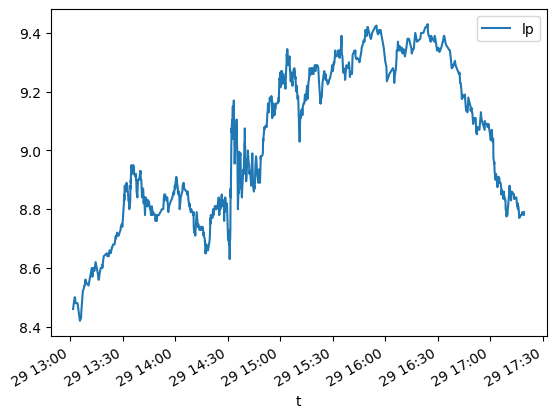

In [109]:
sql = """select t, lp from nyse.prices where t >= now() - interval '1' day and s = 'sofi' and lp is not null"""
db.to_df(sql).plot.line(x='t', y='lp')

Let's focus in on the pattern we are looking for:

<Axes: xlabel='t'>

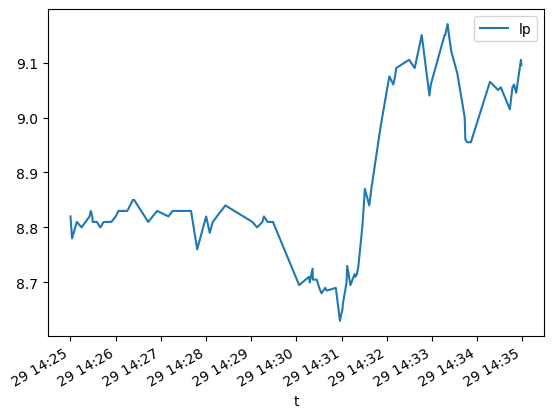

In [114]:
sql = """select t, lp from nyse.prices where t between '2024-01-29 14:25:00' and '2024-01-29 14:35:00' and s = 'sofi' and lp is not null"""
db.to_df(sql).plot.line(x='t', y='lp')

Now that we see the pattern in the data at 14:25 (the big dip followed by an upward trend), lets use that to do a search

In [115]:
sql = """
with query_vector as (
    -- Here we are grabbing the single vector that represents the direable pattern we identified above
    select * from nyse.vector where ts_bkt = '2024-01-29 14:25:00.000' and symbol = 'sofi' limit 1
)
SELECT
        ts_bkt,
        symbol,
        dot_product(ap_vec,(select string(ap_vec) from query_vector)) as d1
    FROM
        nyse.vector
    ORDER BY
        d1 asc
    LIMIT
        5
"""

In [106]:
db.to_df(sql)

,ts_bkt,symbol,d1
0,2024-01-22 15:45:00,qqq,-150224.312500
1,2024-01-19 14:45:00,qqq,-135271.500000
2,2024-01-22 17:05:00,qqq,-123674.156250
3,2024-01-22 16:00:00,qqq,-122803.632812
4,2024-01-22 15:30:00,qqq,-121132.281250


<Axes: xlabel='t'>

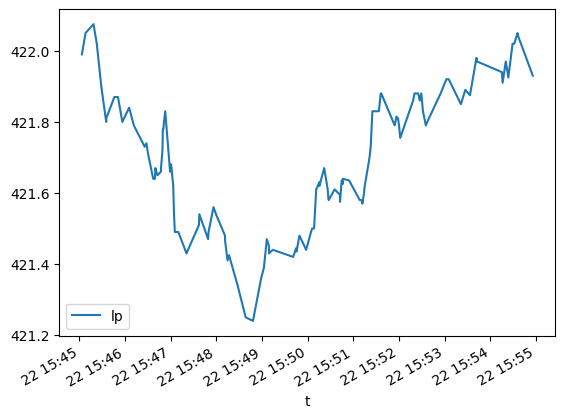

In [117]:
sql = """select t, lp from nyse.prices where s = 'qqq' and t between '2024-01-22 15:45:00' and '2024-01-22 15:55:00' and lp is not null"""
db.to_df(sql).plot.line(x='t', y='lp')